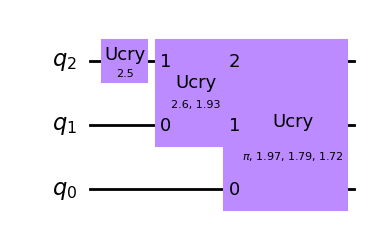

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qcc.quantum.qiskit.convolution import Convolution
from qcc.quantum.qiskit.c2q import C2QAnsatz, C2Q

num_qubits = 3

qc = QuantumCircuit(num_qubits)
qc.compose(C2Q(num_qubits), inplace=True)
qc.assign_parameters(np.arange(qc.num_parameters), inplace=True)

qc.decompose().decompose().draw('mpl', reverse_bits=True)

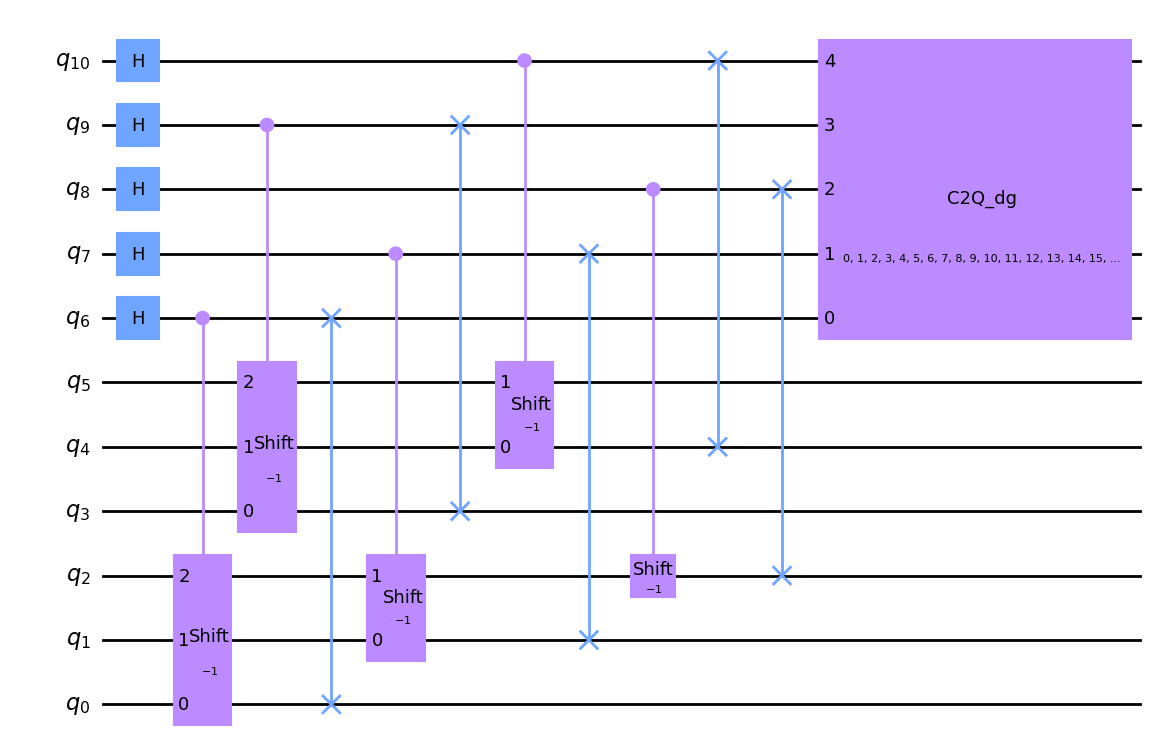

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qcc.quantum.qiskit.convolution import Convolution
from qcc.quantum.qiskit.c2q import C2QAnsatz, C2Q

num_qubits = 3

qc = QuantumCircuit(num_qubits*2 + 5)
qc.compose(Convolution([2**num_qubits, 2**num_qubits], (8, 4)), inplace=True)
qc.assign_parameters(np.arange(qc.num_parameters), inplace=True)

qc.decompose().draw('mpl', reverse_bits=True)

In [1]:
import torch
import numpy as np

from qcc.quantum.qiskit.qcnn import QCNN

qcnn = QCNN.from_dims([16, 16], num_layers=3)

test = qcnn.module

# test.backward(torch.rand((1, test.num_inputs)), torch.rand((1, test.num_weights)))

predictions = test(torch.rand((1, test.neural_network.num_inputs)))

print(predictions)

tensor([[0.6723, 0.3277]], grad_fn=<_TorchNNFunctionBackward>)


/home/mingyoungjeng/Documents/repos/quantum-convolutional-classifier/.env/lib/python3.11/site-packages/qiskit_machine_learning/connectors/torch_connector.py:312: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [3]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

optimizer = Adam(test.parameters())

optimizer.zero_grad()
cost = CrossEntropyLoss()(predictions, torch.tensor([1]))
cost.backward()
optimizer.step()